In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

from utils_analysis import prepare_scores

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
def plot_probs(probs: list[float]):
    plt.bar(x=list(range(len(probs))), height=probs)
    plt.yscale("log")
    plt.ylabel("Sequence Probability")
    plt.ylim((1e-60, 1e-0))
    plt.xlabel("Beam Number")
    plt.show()

In [3]:
# Set path and configuration
metric = "f1"
test_filepath = "/home/mila/f/floresl/beam-search/data/squad/test.csv"
scores_filepath = "/home/mila/f/floresl/beam-search/results/final/bart-base_data_squad_checkpoint-220_squad.json"
temperature = 0.05

In [4]:
# Read in targets, passages, and question
df_test = pd.read_csv(test_filepath)

targets = [str(s) for s in df_test["target"].fillna("")]
passage = [
    str(s) for s in df_test["source"].apply(lambda s: s.split(" | Question:")[0])
]
question = [
    str(s) for s in df_test["source"].apply(lambda s: s.split(" | Question:")[1])
]

# Read in results
results_json = json.load(open(scores_filepath, "r"))

In [5]:
# Extract the scores and their rank (i.e. is this a high or low score, relative to the
# rest of the datset?)
results = prepare_scores(scores_filepath, targets, metric, temperature)  # type: ignore

scores = results.scores_dataframe
scores["target"] = targets
scores["beam_sentences"] = results_json["sentences"]
scores["passage"] = passage
scores["question"] = question

scores["length_normalized_log_probs_rank"] = ss.rankdata(
    -1 * scores["length_normalized_log_probs"]
)
scores["f1_rank"] = ss.rankdata(-1 * scores["f1"])
scores["beam_score_ratios_3_rank"] = ss.rankdata(-1 * scores["beam_score_ratios_3"])

# Extract the log probs by beam, for us to plot later
log_probs = pd.DataFrame(results.scores_by_beam["beam_score_log_probs"]).values

/home/mila/f/floresl/beam-search/analysis/utils_analysis.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore


In [6]:
# Look for examples where both beam search and log probs rank an output as confident
rows_both_calibrated = scores.loc[
    (scores.length_normalized_log_probs_rank < 200)  # type: ignore
    & (scores.beam_score_ratios_3_rank < 200),  # type: ignore
    [
        "length_normalized_log_probs_rank",
        "beam_score_ratios_3_rank",
        "f1",
        "sentences",
        "target",
        "beam_sentences",
        "passage",
        "question",
    ],
].sort_values(by="beam_score_ratios_3_rank")

# Examples: 812, 909, 896
# for i, row in rows_both_calibrated.iterrows():
#     seq_len = 200
#     plt.bar(x=list(range(100)), height=np.exp(seq_len * log_probs[i]))
#     plt.yscale("log")
#     plt.title(i)
#     plt.show()
#     print()

In [7]:
# Look for examples where beam search ranks an output as confident but log probs
# ranks it as unconfident
rows_slope_calibrated = scores.loc[
    (scores.length_normalized_log_probs_rank > 200)  # type: ignore
    & (scores.beam_score_ratios_3_rank < 200),  # type: ignore
    [
        "length_normalized_log_probs_rank",
        "beam_score_ratios_3_rank",
        "f1",
        "sentences",
        "target",
        "beam_sentences",
        "passage",
        "question",
    ],
].sort_values(
    by="beam_score_ratios_3_rank"
)  # type: ignore

# Examples: 375, 993, 451, 849
# for i, row in rows_slope_calibrated.iterrows():
#     seq_len = 200
#     plt.bar(x=list(range(100)), height=np.exp(seq_len * log_probs[i]))
#     plt.yscale("log")
#     plt.title(i)
#     plt.show()
#     print()

# Plots for Paper

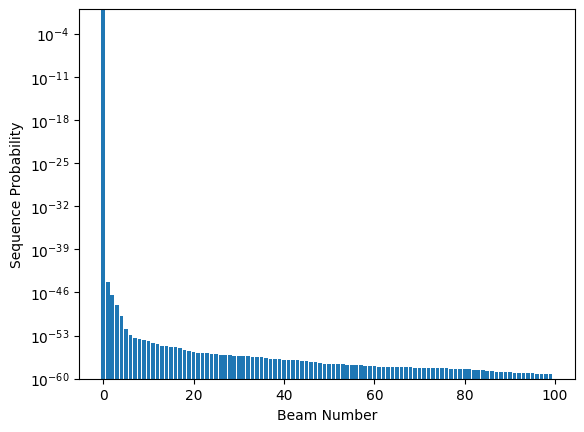

{'length_normalized_log_probs_rank': 3.0, 'beam_score_ratios_3_rank': 2.0, 'f1': 1.0, 'sentences': 'Henry Plitt', 'target': 'Henry Plitt', 'beam_sentences': ['Henry Plitt', 'In April 1970, Congress passed the Public Health Cigarette Smoking Act which banned cigarette advertising from all television and radio networks, including ABC, when it took effect on January 2, 1971', 'In April 1970, Congress passed the Public Health Cigarette Smoking Act which banned cigarette advertising from all television and radio networks', 'In April 1970, Congress passed the Public Health Cigarette Smoking Act which banned cigarette advertising from all television and radio networks, including ABC, when it took effect on January 2, 1971.', 'In April 1970, Congress passed the Public Health Cigarette Smoking Act which banned cigarette advertising from all television and radio networks, including ABC', 'In April 1970, Congress passed the Public Health Cigarette Smoking Act which banned cigarette advertising fr

In [34]:
idx = 812
seq_len = 200
plot_probs(np.exp(seq_len * log_probs[idx]))
print(dict(rows_both_calibrated.loc[idx]))

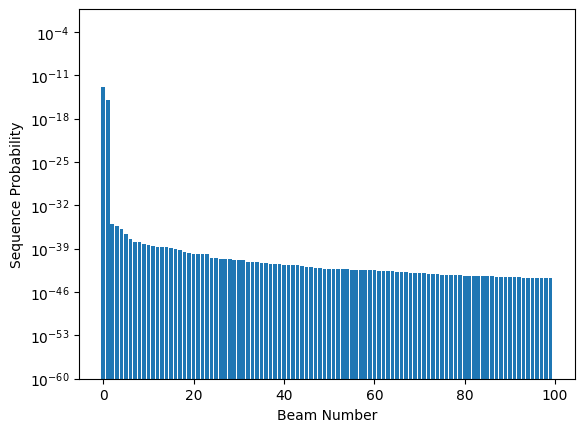

{'length_normalized_log_probs_rank': 596.0, 'beam_score_ratios_3_rank': 174.0, 'f1': 1.0, 'sentences': 'The City of Edinburgh Council', 'target': 'City of Edinburgh Council', 'beam_sentences': ['The City of Edinburgh Council', 'City of Edinburgh Council', "Mayor Assembly Hall, the Parliament's visitors' centre and shop, whilst the main hall was used as the Parliament's principal committee room", "Mayor Assembly Hall, the Parliament Square, High Street and George IV Bridge in Edinburgh (originally built as the headquarters of the pre-1975 Midlothian County Council) housed the Parliament's visitors' centre and shop, whilst the main hall was used as the Parliament's principal committee room", "The General Assembly Hall, the Parliament Square, High Street and George IV Bridge in Edinburgh (originally built as the headquarters of the pre-1975 Midlothian County Council) housed the Parliament's visitors' centre and shop, whilst the main hall was used as the Parliament's principal committee ro

In [25]:
idx = 375
seq_len = 200
plot_probs(np.exp(seq_len * log_probs[idx]))
print(dict(rows_slope_calibrated.loc[idx]))

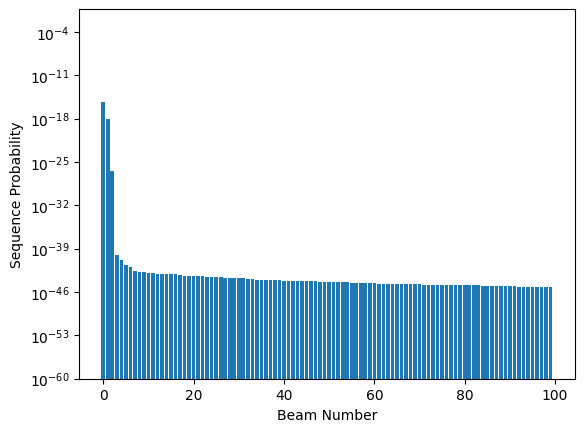

{'length_normalized_log_probs_rank': 685.0, 'beam_score_ratios_3_rank': 119.0, 'f1': 0.6666666666666666, 'sentences': '2 weeks', 'target': '2', 'beam_sentences': ['2 weeks', '2 weeks each year', '2 weeks each year in mid June', '2 weeks each year in mid June. EAT! NewcastleGateshead, a festival of food and drink, runs for 2 weeks each year in mid June', '2 weeks each year in mid June. EAT! NewcastleGateshead, a festival of food and drink, runs for 2 weeks each year in mid June.', '2 weeks each year in mid June.In May, Newcastle and Gateshead host the Evolution Festival, a music festival held on the Newcastle and Gateshead Quaysides over the Spring bank holiday, with performances by acts from the world of Rock, Indie and Dance music, with performances by acts from the world of Rock, Indie and Dance music, with performances by acts from the world of Rock, Indie and Dance music, with performances by acts from the world of Rock, Rock and Dance music, with performances by acts from the worl

In [26]:
idx = 993
seq_len = 200
plot_probs(np.exp(seq_len * log_probs[idx]))
print(dict(rows_slope_calibrated.loc[idx]))

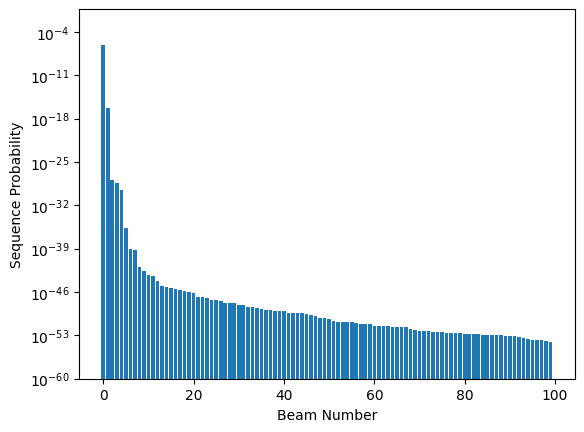

{'length_normalized_log_probs_rank': 336.0, 'beam_score_ratios_3_rank': 176.0, 'f1': 0.6666666666666666, 'sentences': '120 m (390 ft)', 'target': '120 m', 'beam_sentences': ['120 m (390 ft)', '120 m (390 ft) and much of the continental margins became exposed', '120 m (390 ft) and much of the continental margins became exposed.', '180 m (390 ft) and much of the continental margins became exposed', '180 m (390 ft)', '60 m (390 ft) and much of the continental margins became exposed', '200 m (390 ft) and much of the continental margins became exposed', '180 m (390 ft) and much of the continental margins became exposed.', '140 m (390 ft) and much of the continental margins became exposed', '60 m (390 ft)', '120 m (390 ft)The sea level dropped 120 m (390 ft) and much of the continental margins became exposed', ' 120 m (390 ft) and much of the continental margins became exposed', '120 m (390 ft) and much of the continental margins became exposed. Since approximately 600,000 years ago, six maj

In [27]:
idx = 451
seq_len = 200
plot_probs(np.exp(seq_len * log_probs[idx]))
print(dict(rows_slope_calibrated.loc[idx]))

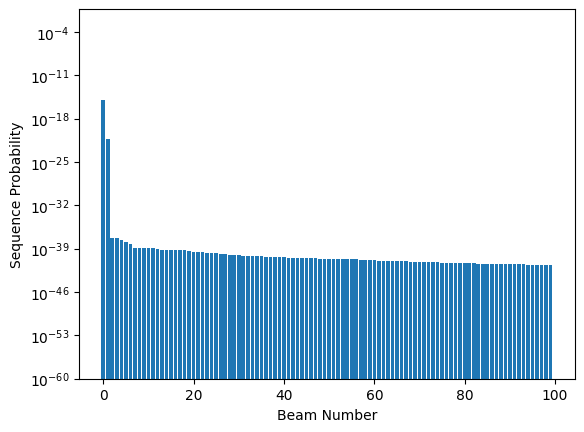

{'length_normalized_log_probs_rank': 672.0, 'beam_score_ratios_3_rank': 175.0, 'f1': 1.0, 'sentences': 'many celebrated seasons', 'target': 'many celebrated seasons', 'beam_sentences': ['many celebrated seasons', 'Many celebrated seasons', 'many celebrated seasons. Stephen Kemble of the famous Kemble family successfully managed the original Theatre Royal, Newcastle for fifteen years (1791–1806). He brought members of his famous acting family such as Sarah Siddons and John Kemble out of London to Newcastle', 'many celebrated seasons. Stephen Kemble of the famous Kemble family successfully managed the original Theatre Royal, Newcastle for fifteen years (1791–1806). He brought members of his famous acting family such as Sarah Siddons and John Kemble out of London to Newcastle; he brought members of his famous acting family such as Sarah Siddons and John Kemble out of London to Newcastle; he brought members of his famous acting family such as Sarah Siddons and John Kemble out of London to 

In [28]:
idx = 849
seq_len = 200
plot_probs(np.exp(seq_len * log_probs[idx]))
print(dict(rows_slope_calibrated.loc[idx]))